In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

import sklearn.svm as sks
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from torchinfo import summary
from numba import jit
import os


/home/sarvagya/anaconda3/envs/torch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_dir = os.getcwd()

In [3]:
img_files = os.listdir(base_dir+'/train/')
img_files = list(filter(lambda x: x != 'train', img_files))
def train_path(p): return f"/train/{p}"
img_files = list(map(train_path, img_files))

print("total training images", len(img_files))
print("First item", img_files[0])


total training images 25000
First item /train/cat.4607.jpg


In [4]:
# create train-test split
random.shuffle(img_files)

train = img_files[:20000]
test = img_files[20000:]

print("train size", len(train))
print("test size", len(test))


train size 20000
test size 5000


In [5]:
# image normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# preprocessing of images
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)


In [12]:
# create train dataset
train_ds = CatDogDataset(train, transform)
train_dl = DataLoader(train_ds, batch_size=100)
print(len(train_ds), len(train_dl))

# create test dataset
test_ds = CatDogDataset(test, transform)
test_dl = DataLoader(test_ds, batch_size=100)
print(len(test_ds), len(test_dl))


20000 200
5000 50


In [23]:
idx = []
for data,label in train_ds:
    idx.append(label)

In [24]:
unique_elements, counts_elements = np.unique(idx, return_counts=True)
print(counts_elements)

[ 9994 10006]


[Text(0.5, 1.0, 'Data Distribution'), Text(0, 0.5, 'Frequency')]

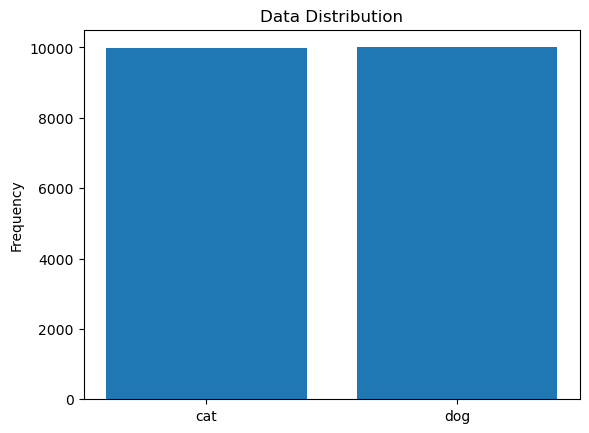

In [25]:
plt.bar(['cat','dog'], counts_elements)
plt.gca().set(title='Data Distribution', ylabel='Frequency')

In [7]:
# Pytorch Convolutional Neural Network Model Architecture
class CatAndDogConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # onvolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.maxpool_1 = nn.MaxPool2d(2)
        self.relu_1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.maxpool_2 = nn.MaxPool2d(2)
        self.relu_2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.maxpool_3 = nn.MaxPool2d(2)
        self.relu_3 = nn.ReLU()
        self.flatten = nn.Flatten(0,2)

        # conected layers
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.relu_4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.relu_5 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):
        # print(X.shape)

        X = self.maxpool_1(self.relu_1(self.conv1(X)))
        # print(X.shape)
        X = self.maxpool_2(self.relu_2(self.conv2(X)))
        # print(X.shape)
        X = self.maxpool_3(self.relu_2(self.conv3(X)))
        print(X.shape)
        # X = X.view(X.shape[0], -1)
        X = self.flatten(X)
        print(X.shape)
        X = self.relu_4(self.fc1(X))
        X = self.relu_5(self.fc2(X))
        X = self.fc3(X)

        return X


In [101]:
# # Create instance of the model
# model = CatAndDogConvNet()
# total_test_acc = []
# total_test_loss = []

# losses = []
# accuracies = []
# epoches = 8
# start = time.time()
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# # Model Training...
# for epoch in range(epoches):

#     epoch_loss = 0
#     epoch_accuracy = 0

#     for X, y in train_dl:

#         preds = model(X)
#         loss = loss_fn(preds, y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         accuracy = ((preds.argmax(dim=1) == y).float().mean())
#         epoch_accuracy += accuracy
#         epoch_loss += loss
#         print('.', end='', flush=True)

#     epoch_accuracy = epoch_accuracy/len(train_dl)
#     accuracies.append(epoch_accuracy)
#     epoch_loss = epoch_loss / len(train_dl)
#     losses.append(epoch_loss)

#     print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))

#     # test set accuracy
#     with torch.no_grad():

#         test_epoch_loss = 0
#         test_epoch_accuracy = 0

#         for test_X, test_y in test_dl:

#             test_preds = model(test_X)
#             test_loss = loss_fn(test_preds, test_y)

#             test_epoch_loss += test_loss            
#             test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
#             test_epoch_accuracy += test_accuracy

#         test_epoch_accuracy = test_epoch_accuracy/len(test_dl)
#         total_test_acc.append(test_epoch_accuracy)
#         test_epoch_loss = test_epoch_loss / len(test_dl)
#         total_test_loss.append(test_epoch_loss)

#         print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy, time.time() - start))


In [102]:
# torch.save(model.state_dict(), 'ML_project.pt')

In [8]:
model = CatAndDogConvNet()
model.load_state_dict(torch.load('ML_project.pt'))
model = model.cpu()

In [28]:
# for i in range(len(losses)):
#     temp = losses[i]
#     temp = temp.cpu().detach().numpy()
#     losses[i] = temp
# for i in range(len(total_test_loss)):
#     temp = total_test_loss[i]
#     temp = temp.cpu().detach().numpy()
#     total_test_loss[i] = temp

# epochs = range(1,epoches+1)
# plt.plot(epochs, losses, 'g', label='Training loss')
# plt.plot(epochs, total_test_loss, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [29]:
# # for i in range(len(accuracies)):
# #     temp = accuracies[i]
# #     temp = temp.cpu().detach().numpy()
# #     accuracies[i] = temp
# # for i in range(len(total_test_acc)):
# #     temp = total_test_acc[i]
# #     temp = temp.cpu().detach().numpy()
# #     total_test_acc[i] = temp

# epochs = range(1,epoches+1)
# plt.plot(epochs, accuracies, 'g', label='Training acc')
# plt.plot(epochs, total_test_acc, 'b', label='validation acc')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Acc')
# plt.legend()
# plt.show()

In [9]:
test_ds = CatDogDataset(test, transform)
test_dl = DataLoader(test_ds, batch_size=1)
# test_dl = test_dl.cuda()

In [10]:
# num_test_examples = len(test_dl)
# indices = torch.randperm(num_test_examples)[:100]
# random_test_dataset = SubsetRandomSampler(test_dl, indices)

# random_test_dataloader = DataLoader(test_dl, batch_size=1, sampler=random_test_dataset)
# test_dataset = torch.utils.data.DataLoader(...)

# Get a random subset of 100 samples from the test dataset
random_indices = torch.randperm(len(test_dl))[:1000]
random_samples = [test_dl.dataset[i] for i in random_indices]
# print(len(random_samples))
print(random_samples[0][0].shape)

FileNotFoundError: [Errno 2] No such file or directory: '/train/dog.10974.jpg'

In [11]:
res_1 = []
model_new = torch.nn.Sequential(*list(model.children())[:3]).cpu()
for i in range(len(random_samples)):
    temp = model_new(random_samples[i][0])
    res_1.append([temp, random_samples[i][1]])

NameError: name 'random_samples' is not defined

In [12]:
res_2 = []
model_new = torch.nn.Sequential(*list(model.children())[:6]).cpu()
for i in range(len(random_samples)):
    temp = model_new(random_samples[i][0])
    res_2.append([temp, random_samples[i][1]])
print(res_2[0][0].shape)
len(res_2)

torch.Size([32, 13, 13])


1000

In [13]:
res_3 = []
model_new = torch.nn.Sequential(*list(model.children())[:9]).cpu()
for i in range(len(random_samples)):
    temp = model_new(random_samples[i][0])
    res_3.append([temp, random_samples[i][1]])
print(res_3[0][0].shape)

torch.Size([64, 6, 6])


In [14]:
res_4 = []
model_new = torch.nn.Sequential(*list(model.children())[:12]).cpu()
# print(model_new)
for i in range(len(random_samples)):
    # print(imgs[i][0].shape)
    temp = model_new.forward(random_samples[i][0])
    res_4.append([temp, random_samples[i][1]])

In [15]:
res_5 = []
model_new = torch.nn.Sequential(*list(model.children())[:14]).cpu()
# print(model_new)
for i in range(len(random_samples)):
    # print(imgs[i][0].shape)
    temp = model_new.forward(random_samples[i][0])
    res_5.append([temp, random_samples[i][1]])

In [17]:
train_sizes = [10,40,80,100,150,200,300, 400,500,600]

In [32]:
@jit
def svm_1st():
    X_1 = np.zeros([1000,16*55*55]) #48400
    y_1 = np.zeros([1000])
    for i in range(len(res_1)):
        tmp = res_1[i][0]
        tmp = np.squeeze(tmp.detach().numpy())
        tmp = tmp.flatten()
        X_1[i] = tmp
        y_1[i] = res_1[i][1]


    X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2)
    model_svm_1 = sks.SVC(probability=True)
    model_svm_1.fit(X_1_train, y_1_train)
    train_accuracy = model_svm_1.score(X_1_train, y_1_train)
    accuracy = model_svm_1.score(X_1_test, y_1_test)

    print(train_accuracy)
    print(accuracy)

    predictions = model_svm_1.predict(X_1_test)


    train_sizes = [10,40,80,100,150,200,300, 400,500,600]
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model_svm_1,
    X = X_1_train,
    y = y_1_train, train_sizes = train_sizes,
    scoring = 'neg_log_loss', )

    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curve for SVM for first layer', fontsize = 18, y = 1.03)
    plt.ylim(0,2)
    plt.legend()



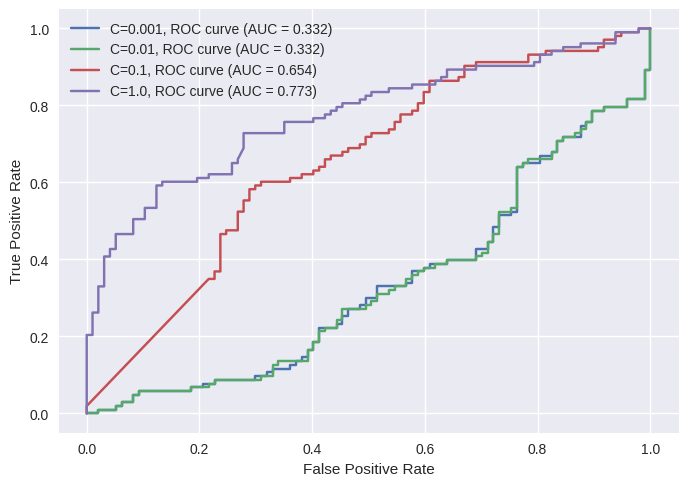

In [33]:
reg_values = [0.001, 0.01, 0.1, 1.0]
fig, ax = plt.subplots()

for reg in reg_values:
    # Create and fit SVM model
    model_svm_1 = sks.SVC(C=reg, probability=True)
    model_svm_1.fit(X_1_train, y_1_train)
    
    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(y_1_test, model_svm_1.predict_proba(X_1_test)[:,1])
    
    auc = roc_auc_score(y_1_test, model_svm_1.predict_proba(X_1_test)[:,1])
    # Plot ROC curve
    ax.plot(fpr, tpr, label='C={}, ROC curve (AUC = {:.3f})'.format(reg, auc))

# Add labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show plot
plt.show()

In [30]:
X_2 = np.zeros([1000,32*13*13]) #5408
y_2 = np.zeros([1000],dtype=int)
for i in range(len(res_2)):
    tmp = res_2[i][0]
    tmp = np.squeeze(tmp.detach().numpy())
    tmp = tmp.flatten()
    X_2[i] = tmp
    y_2[i] = int(res_2[i][1])


X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2)
model_svm_2 = sks.SVC(probability=True)
model_svm_2.fit(X_2_train, y_2_train)
train_accuracy = model_svm_2.score(X_2_train, y_2_train)
accuracy = model_svm_2.score(X_2_test, y_2_test)

print(train_accuracy)
print(accuracy)

predictions = model_svm_2.predict(X_2_test)

# train_sizes = [10,40,80,100,150,200,300]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = model_svm_2,
X = X_2_train,
y = y_2_train, train_sizes = train_sizes,
scoring = 'neg_log_loss',
verbose=2)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for SVM for Second layer', fontsize = 18, y = 1.03)
plt.ylim(0,2)
plt.legend()


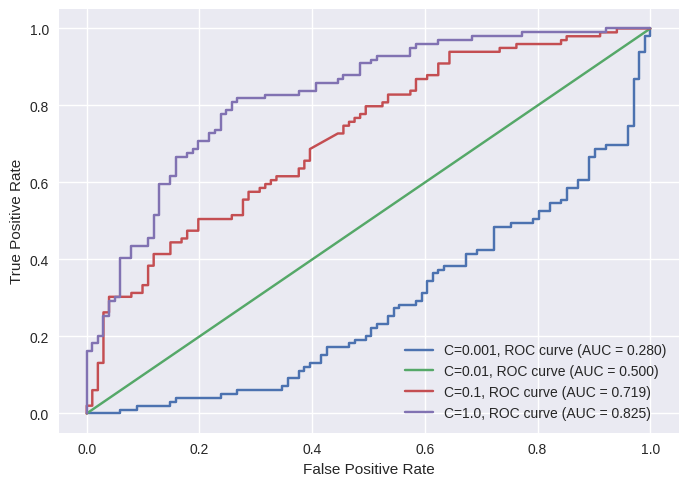

In [31]:
reg_values = [0.001, 0.01, 0.1, 1.0]
fig, ax = plt.subplots()

for reg in reg_values:
    # Create and fit SVM model
    model_svm_2 = sks.SVC(C=reg, probability=True)
    model_svm_2.fit(X_2_train, y_2_train)
    
    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(y_2_test, model_svm_2.predict_proba(X_2_test)[:,1])
    
    auc = roc_auc_score(y_2_test, model_svm_2.predict_proba(X_2_test)[:,1])
    # Plot ROC curve
    ax.plot(fpr, tpr, label='C={}, ROC curve (AUC = {:.3f})'.format(reg, auc))

# Add labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show plot
plt.show()

In [28]:
X_3 = np.zeros([1000,64*6*6]) #2304
y_3 = np.zeros([1000], dtype=int)
for i in range(len(res_3)):
    tmp = res_3[i][0]
    tmp = np.squeeze(tmp.detach().numpy())
    tmp = tmp.flatten()
    X_3[i] = tmp
    y_3[i] = res_3[i][1]

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2)
model_svm_3 = sks.SVC(probability=True)
model_svm_3.fit(X_3_train, y_3_train)
train_accuracy = model_svm_3.score(X_3_train, y_3_train)
accuracy = model_svm_3.score(X_3_test, y_3_test)

print(train_accuracy)
print(accuracy)

predictions = model_svm_3.predict(X_3_test)


# train_sizes = [10,40,80,100,150,200,300]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = model_svm_3,
X = X_3_train,
y = y_3_train, train_sizes = train_sizes,
scoring = 'neg_log_loss',
verbose=1)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for SVM for Third layer', fontsize = 18, y = 1.03)
plt.ylim(0,2)
plt.legend()


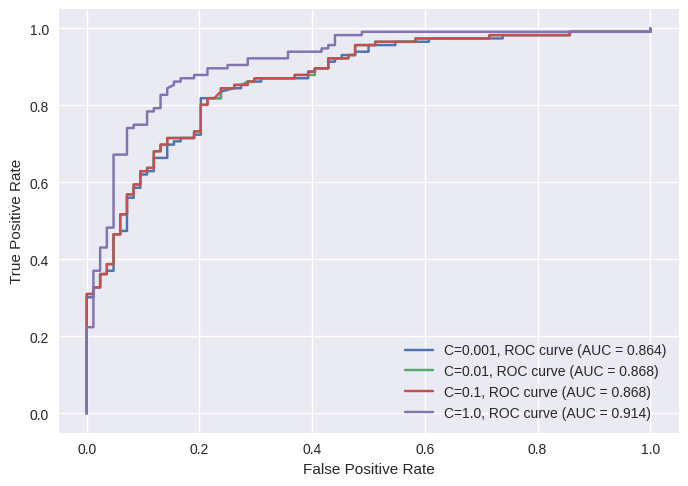

In [29]:
reg_values = [0.001, 0.01, 0.1, 1.0]
fig, ax = plt.subplots()

for reg in reg_values:
    # Create and fit SVM model
    model_svm_3 = sks.SVC(C=reg, probability=True)
    model_svm_3.fit(X_3_train, y_3_train)
    
    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(y_3_test, model_svm_3.predict_proba(X_3_test)[:,1])
    
    auc = roc_auc_score(y_3_test, model_svm_3.predict_proba(X_3_test)[:,1])
    # Plot ROC curve
    ax.plot(fpr, tpr, label='C={}, ROC curve (AUC = {:.3f})'.format(reg, auc))

# Add labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show plot
plt.show()

In [22]:
X_4 = np.zeros([1000,500]) 
y_4 = np.zeros([1000], dtype=int)
for i in range(len(res_4)):
    tmp = res_4[i][0]
    tmp = np.squeeze(tmp.detach().numpy())
    tmp = tmp.flatten()
    X_4[i] = tmp
    y_4[i] = res_4[i][1]


X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=0.2)
model_svm_4 = sks.SVC(probability=True)
model_svm_4.fit(X_4_train, y_4_train)
train_accuracy = model_svm_4.score(X_4_train, y_4_train)
accuracy = model_svm_4.score(X_4_test, y_4_test)

print(train_accuracy)
print(accuracy)

predictions = model_svm_4.predict(X_4_test)


# train_sizes = [10,40,80,100,150,200,300]
train_sizes, train_scores, validation_scores = learning_curve(
estimator = model_svm_4,
X = X_4_train,
y = y_4_train, train_sizes = train_sizes,
scoring = 'neg_log_loss')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for SVM for Forth layer', fontsize = 18, y = 1.03)
plt.ylim(0,2)
plt.legend()



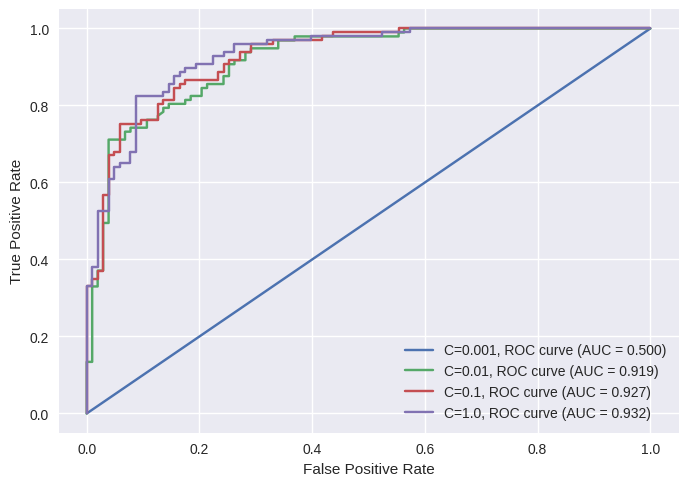

In [25]:
reg_values = [0.001, 0.01, 0.1, 1.0]
fig, ax = plt.subplots()

for reg in reg_values:
    # Create and fit SVM model
    model_svm_4 = sks.SVC(C=reg, probability=True)
    model_svm_4.fit(X_4_train, y_4_train)
    
    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(y_4_test, model_svm_4.predict_proba(X_4_test)[:,1])
    auc = roc_auc_score(y_4_test, model_svm_4.predict_proba(X_4_test)[:,1])
    # Plot ROC curve
    ax.plot(fpr, tpr, label='C={}, ROC curve (AUC = {:.3f})'.format(reg, auc))

# Add labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show plot
plt.show()

0.88125
0.85


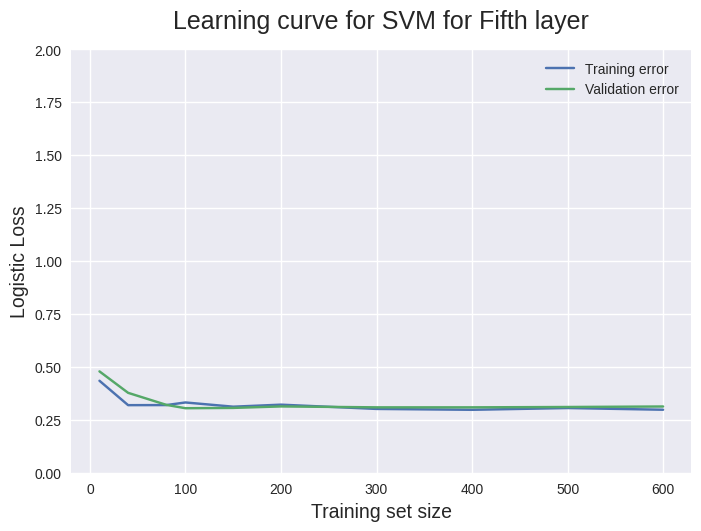

In [19]:
X_5 = np.zeros([1000,50]) 
y_5 = np.zeros([1000],dtype=int)
for i in range(len(res_5)):
    tmp = res_5[i][0]
    tmp = np.squeeze(tmp.detach().numpy())
    tmp = tmp.flatten()
    X_5[i] = tmp
    y_5[i] = res_5[i][1]


X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X_5, y_5, test_size=0.2)
model_svm_5 = sks.SVC(probability=True)
model_svm_5.fit(X_5_train, y_5_train)
train_accuracy = model_svm_5.score(X_5_train, y_5_train)
accuracy = model_svm_5.score(X_5_test, y_5_test)

print(train_accuracy)
print(accuracy)

predictions = model_svm_5.predict(X_5_test)


# train_sizes = [10,40,80,100,150,200,300]
params = {'iter':[0.001,0.01,0.1,1]}
train_sizes, train_scores, validation_scores = learning_curve(
estimator = model_svm_5,
X = X_5_train,
y = y_5_train, train_sizes = train_sizes, scoring = 'neg_log_loss')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Logistic Loss', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curve for SVM for Fifth layer', fontsize = 18, y = 1.03)
plt.ylim(0,2)
plt.legend()

# print(np.unique(y_5))


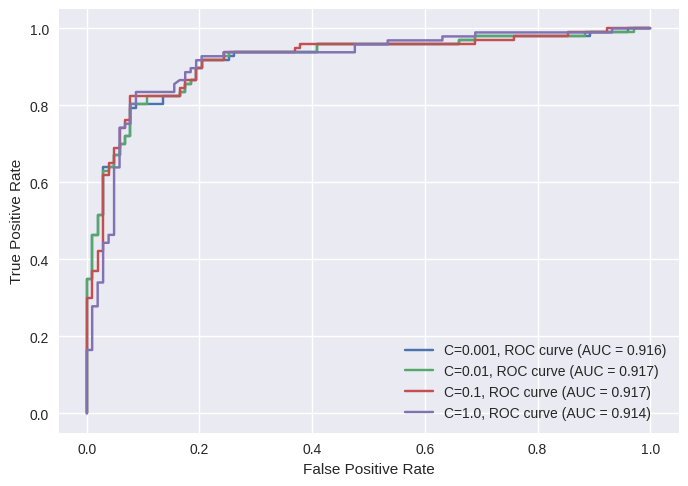

In [27]:
reg_values = [0.001, 0.01, 0.1, 1.0]
fig, ax = plt.subplots()

for reg in reg_values:
    # Create and fit SVM model
    model_svm_5 = sks.SVC(C=reg, probability=True)
    model_svm_5.fit(X_5_train, y_5_train)
    
    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(y_5_test, model_svm_5.predict_proba(X_5_test)[:,1])
    
    auc = roc_auc_score(y_5_test, model_svm_5.predict_proba(X_5_test)[:,1])
    # Plot ROC curve
    ax.plot(fpr, tpr, label='C={}, ROC curve (AUC = {:.3f})'.format(reg, auc))

# Add labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

# Show plot
plt.show()